In [1]:
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt

from gprob import normal, stack

# Basic operation

Creating a scalar random variable

In [2]:
v = normal(0, 1)  # or simply normal()
v

Normal(mean=0, var=1)

In [3]:
v.sample()

array(1.62434536)

Creating a vector of correlated variables by specifying their mean and covariance

In [4]:
x = normal(mu=[-1, 2], sigmasq=[[1, 0.5], [0.5, 1]])
x.cov()

array([[1. , 0.5],
       [0.5, 1. ]])

Normal variables can be used in arithmetic operations

In [5]:
v1 = normal()
v2 = normal()
v3 = normal()
v4 = normal()

v1 = v1 + 0.93
v5 = v3 - 2 * v4

and concatenated together as

In [6]:
vm1 = stack([v1, v2])

or

In [7]:
vm2 = v2 & v4

The joint distribution for `v1` and `v2` is for now a product distribution

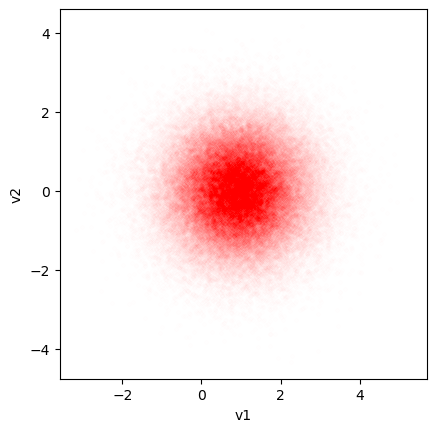

In [8]:
samples = vm1.sample(10**5)
plt.plot(samples[:, 0], samples[:, 1], 'r.', alpha=0.005)
plt.xlabel('v1')
plt.ylabel('v2')
plt.gca().set_aspect('equal')

We can check that `vm2` and `v5` are correlated, because they both depend on `v4`, while `vm1` and `v5` are not

In [9]:
((vm2 & v5).cov(), (vm1 & v5).cov())

(array([[ 1.,  0.,  0.],
        [ 0.,  1., -2.],
        [ 0., -2.,  5.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 5.]]))

The variables can be conditioned on a set of observations using `|` operation. For example, the distribution of `v1` and `v2` under the condition that their sum is 1 is obtained as (named `vc`) 

In [10]:
vc = (v1 & v2) | {v1 + v2: 1}

By sampling from the conditional distribution, we can verify that `v1+v2==1` is indeed satisfied

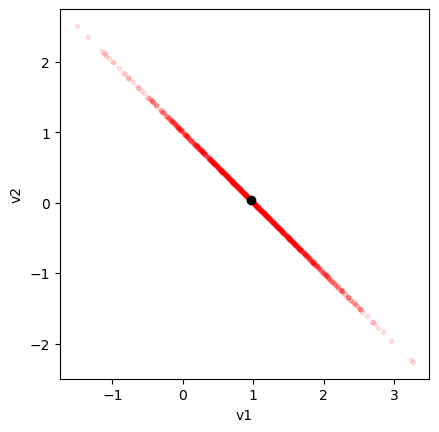

In [11]:
samples = vc.sample(10**3)
plt.plot(samples[:, 0], samples[:, 1], 'r.', alpha=0.1)
plt.xlabel('v1')
plt.ylabel('v2')
plt.plot(*vc.mean(), 'ko')
plt.gca().set_aspect('equal')

The conditional mean and covariance

In [12]:
(vc.mean(), vc.cov())

(array([0.965, 0.035]),
 array([[ 0.5, -0.5],
        [-0.5,  0.5]]))

The original variables remain unaffected - conditioning has no side effects

In [13]:
(v1 & v2).cov()

array([[1., 0.],
       [0., 1.]])

# Random Walk

A random walk

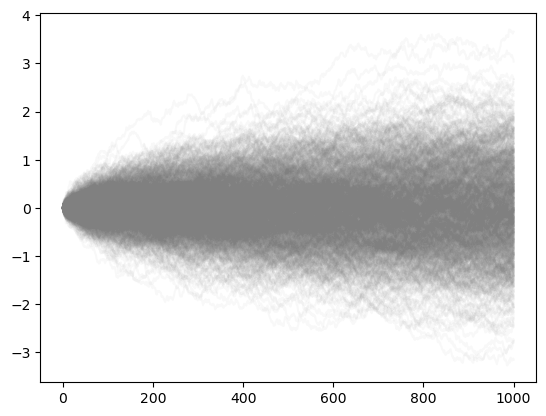

In [14]:
nstep = 10**3
nsample = 10**3

x = [0] * (nstep + 1)
for i in range(nstep):
    x[i+1] = x[i] + normal(0, 1/nstep)

xs = stack(x)
samples = xs.sample(nsample)

plt.plot(samples.T, alpha=0.05, color='gray');

Conditioning the random walk on several observations

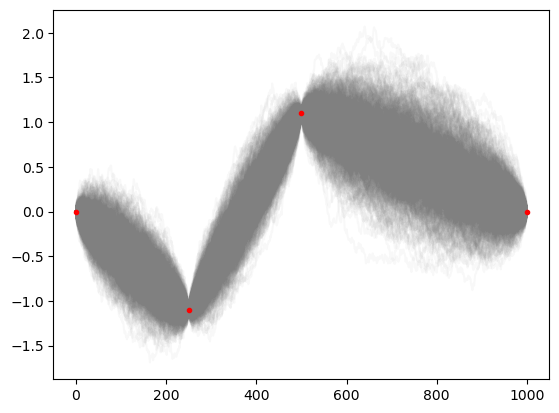

In [15]:
steps = [0, nstep//4, nstep//2, len(x)-1]
obs = [0, -1.1, 1.1, 0]

xs = stack(x) | {x[i]: v for i, v in zip(steps, obs)}
samples = xs.sample(nsample)

plt.plot(samples.T, alpha=0.05, color='gray')
plt.plot(steps, obs, color='r', marker='.', ls='none');